# LLM Embedding Dimensionality Reduction (Prompts + Answers)

_Reproducible notebook for PCA/t-SNE, neighborhood preservation, and k-means metrics._

**Notes**
- Figures use a consistent, colorblind-safe palette (Okabe–Ito), no in-plot titles, 300+ dpi, consistent styling.
- Analyses run on **combined** dataset (prompts **and** answers) after cleaning and ID matching.
- Neighborhood preservation uses trustworthiness and k-NN retention; no cluster-label assumptions.

In [ ]:
# Imports & global style (COLOR, consistent fonts)
import ast, os, json
import numpy as np, pandas as pd
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

np.random.seed(42)

# Colorblind-safe Okabe–Ito palette
PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#E69F00', '#56B4E9', '#F0E442', '#000000']

plt.style.use('default')
mpl.rcParams.update({
    'font.size': 10,
    'font.family': 'DejaVu Sans',
    'axes.labelsize': 10,
    'axes.edgecolor': '0.2',
    'axes.linewidth': 0.8,
    'xtick.color': '0.2',
    'ytick.color': '0.2',
    'grid.color': '0.85',
    'grid.linestyle': ':',
    'axes.grid': True,
    'axes.prop_cycle': cycler(color=PALETTE),
})

def savefig_gray(path, fig=None, dpi=350):
    """Name kept for minimal diffs; now a hi-DPI color save."""
    if fig is None:
        fig = plt.gcf()
    fig.savefig(path, dpi=dpi, bbox_inches='tight', facecolor='white')

def ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)
    return str(p)

# Convenience color aliases
C0, C1, C2 = PALETTE[0], PALETTE[1], PALETTE[2]

In [ ]:
# Config
PROMPTS_CSV = 'prompts.csv'   # expects columns: prompt, distance, uuid, embedding
ANSWERS_CSV = 'answers.csv'   # expects columns: answer, distance, prompt_id, embedding
OUTDIR = ensure_dir('report_with_images_assets')

# PCA/TSNE params
PCA_FIT_COMPONENTS = 10   # fit to 10, keep first 3 for plotting
TSNE_COMPONENTS = 3
TSNE_PERPLEXITY = 30

# Neighborhood k values
K_VALUES = [5, 10, 15, 30, 50]

# k-means settings
KMEANS_RANDOM_STATE = 42
K_RANGE = list(range(2, 11))  # for across-k figures
K_FINAL = 5                    # main table/plots as in paper

## Load & Parse (Prompts and Answers)

In [ ]:
def parse_embedding(cell):
    """Parse an embedding stored as a string like "[0.1, 0.2, ...]" into a list of floats.
    Returns None if parsing fails."""
    if isinstance(cell, (list, np.ndarray)):
        return list(cell)
    if not isinstance(cell, str):
        return None
    try:
        v = ast.literal_eval(cell)
        if isinstance(v, (list, tuple)):
            return [float(x) for x in v]
        return None
    except Exception:
        return None

# Load CSVs
prompts_df = pd.read_csv(PROMPTS_CSV)
answers_df = pd.read_csv(ANSWERS_CSV)

# Standardize column names we use
prompts_df = prompts_df.rename(columns={'prompt': 'prompt_text', 'uuid': 'prompt_uuid'})
answers_df = answers_df.rename(columns={'answer': 'answer_text'})

# Parse embeddings
prompts_df['embedding_array'] = prompts_df['embeddings'].apply(parse_embedding)
answers_df['embedding_array'] = answers_df['embeddings'].apply(parse_embedding)

print('Loaded prompts:', len(prompts_df), '| answers:', len(answers_df))
print('Parsed embeddings (non-null) prompts:', prompts_df['embedding_array'].notna().sum(),
      '| answers:', answers_df['embedding_array'].notna().sum())

Loaded prompts: 6005 | answers: 17955
Parsed embeddings (non-null) prompts: 6005 | answers: 17955


## Cleaning & Filtering (Math-only + ID matching)

In [ ]:
# Math-only filter for prompts (user-provided keywords)
math_keywords = [
    'solve', 'find', 'calculate', 'determine', 'evaluate', 'simplify',
    'equation', 'expression', 'function', 'graph', 'area', 'volume',
    'perimeter', 'probability', 'statistics', 'mean', 'median', 'mode',
    'standard deviation', 'integral', 'derivative', 'algebra', 'geometry',
    'calculus', 'math problem', 'word problem', 'prove'
]

def is_math_prompt(text: str) -> bool:
    if not isinstance(text, str):
        return False
    low = text.lower()
    return any(kw in low for kw in math_keywords)

prompts_df['is_math'] = prompts_df['prompt_text'].apply(is_math_prompt)
prompts_df = prompts_df[prompts_df['is_math'] & prompts_df['embedding_array'].notna()].copy()
prompts_df.reset_index(drop=True, inplace=True)
print('Prompts after math filter & embedding present:', len(prompts_df))

# Keep answers that: (a) have an embedding AND (b) prompt_id exists in cleaned prompt uuids
valid_prompt_ids = set(prompts_df['prompt_uuid'].dropna().astype(str))
answers_df['prompt_id'] = answers_df['prompt_id'].astype(str)
answers_df = answers_df[answers_df['embedding_array'].notna() & answers_df['prompt_id'].isin(valid_prompt_ids)].copy()
answers_df.reset_index(drop=True, inplace=True)
print('Answers after ID match & embedding present:', len(answers_df))

# Rebuild prompt_index to match the cleaned dataframe indices
prompts_df['prompt_index'] = range(len(prompts_df))

# Ensure embedding dimension consistency
def _len_or_minus1(v):
    try:
        return len(v)
    except Exception:
        return -1
dim_prompts = prompts_df['embedding_array'].dropna().map(_len_or_minus1).mode()[0]
dim_answers = answers_df['embedding_array'].dropna().map(_len_or_minus1).mode()[0]
assert dim_prompts == dim_answers, f"Embedding dim mismatch: prompts {dim_prompts} vs answers {dim_answers}"
print('Embedding dimension:', dim_prompts)

Prompts after math filter & embedding present: 3458
Answers after ID match & embedding present: 10348
Embedding dimension: 384


## Build Combined Dataset (prompts + answers)

In [ ]:
# Build unified dataframe with type tags and a stable ID
prom_tbl = prompts_df[['prompt_uuid', 'prompt_text', 'embedding_array']].copy()
prom_tbl['item_type'] = 'prompt'
prom_tbl = prom_tbl.rename(columns={'prompt_uuid': 'item_id', 'prompt_text': 'text'})

ans_tbl = answers_df[['prompt_id', 'answer_text', 'embedding_array']].copy()
ans_tbl['item_type'] = 'answer'
ans_tbl = ans_tbl.rename(columns={'prompt_id': 'item_id', 'answer_text': 'text'})

combined_df = pd.concat([prom_tbl, ans_tbl], axis=0, ignore_index=True)
combined_embeddings = np.vstack(combined_df['embedding_array'].values)

print('Combined records:', len(combined_df), '| Embedding matrix:', combined_embeddings.shape)

# Save cleaning summary
summary = {
    'n_prompts': int(len(prompts_df)),
    'n_answers': int(len(answers_df)),
    'n_combined': int(len(combined_df)),
    'embedding_dim': int(dim_prompts)
}
with open(os.path.join(OUTDIR, 'cleaning_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

Combined records: 13806 | Embedding matrix: (13806, 384)


## Dimensionality Reduction (PCA 3D, t-SNE 3D)

In [ ]:
# PCA fit to 10 components, keep first 3 for plots/metrics
pca = PCA(n_components=PCA_FIT_COMPONENTS, random_state=42)
X_pca_full = pca.fit_transform(combined_embeddings)
X_pca3 = X_pca_full[:, :3]
pca_var3 = pca.explained_variance_ratio_[:3].sum()
print(f'PCA: variance explained by first 3 = {pca_var3:.4f}')

# Explained variance plot (no title)
fig, ax = plt.subplots(figsize=(4.5, 3.0))
ax.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color=C0)
ax.set_xlabel('Component')
ax.set_ylabel('Explained variance ratio')
savefig_gray(os.path.join(OUTDIR, 'pca_explained_variance.png'), fig)
plt.close(fig)

# t-SNE to 3D
tsne = TSNE(n_components=TSNE_COMPONENTS, perplexity=TSNE_PERPLEXITY, init='pca', learning_rate='auto', random_state=42)
X_tsne3 = tsne.fit_transform(combined_embeddings)
print('t-SNE shape:', X_tsne3.shape)

# 3D scatter (PCA, then t-SNE) with subtle grayscale points
def scatter3d_gray(X3, path, color=None):
    fig = plt.figure(figsize=(4.5, 4.0))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X3[:,0], X3[:,1], X3[:,2], s=6, c=(color or C0), alpha=0.7, depthshade=False)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    savefig_gray(path, fig)
    plt.close(fig)

scatter3d_gray(X_pca3, os.path.join(OUTDIR, 'pca_3d_scatter.png'))
scatter3d_gray(X_tsne3, os.path.join(OUTDIR, 'tsne_3d_scatter.png'))

PCA: variance explained by first 3 = 0.1802
t-SNE shape: (13806, 3)


## Neighborhood Preservation (Trustworthiness & k-NN retention)

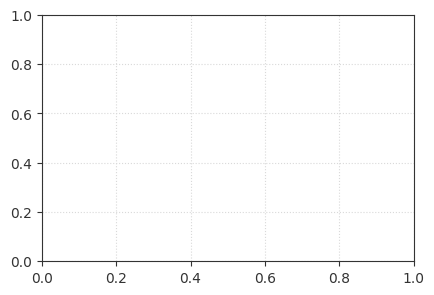

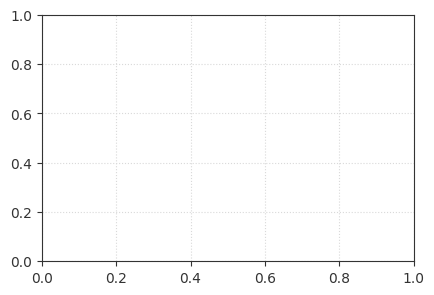

In [ ]:
def compute_trustworthiness_across_k(X_high, X_low, k_values):
    res = []
    for k in k_values:
        t = trustworthiness(X_high, X_low, n_neighbors=k, metric='euclidean')
        res.append({'k': k, 'trustworthiness': t})
    return pd.DataFrame(res)

def knn_indices(X, k):
    # exclude self by using n_neighbors=k+1 then drop the first column
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(X)
    distances, indices = nbrs.kneighbors(X)
    return indices[:, 1:]

def compute_knn_retention(X_ref, X_low, k_values):
    # For each point, compute fraction of original k-NN retained in the low-D space
    res = []
    for k in k_values:
        idx_ref = knn_indices(X_ref, k)
        idx_low = knn_indices(X_low, k)
        # Compute per-row recall
        recalls = []
        for a, b in zip(idx_ref, idx_low):
            s = len(set(a).intersection(set(b))) / float(k)
            recalls.append(s)
        res.append({'k': k, 'knn_retention': float(np.mean(recalls))})
    return pd.DataFrame(res)

# Compute metrics
tw_pca = compute_trustworthiness_across_k(combined_embeddings, X_pca3, K_VALUES)
tw_tsne = compute_trustworthiness_across_k(combined_embeddings, X_tsne3, K_VALUES)
kr_pca = compute_knn_retention(combined_embeddings, X_pca3, K_VALUES)
kr_tsne = compute_knn_retention(combined_embeddings, X_tsne3, K_VALUES)

# Save CSVs
tw_pca.assign(method='PCA').to_csv(os.path.join(OUTDIR, 'trustworthiness_pca.csv'), index=False)
tw_tsne.assign(method='tSNE').to_csv(os.path.join(OUTDIR, 'trustworthiness_tsne.csv'), index=False)
kr_pca.assign(method='PCA').to_csv(os.path.join(OUTDIR, 'knn_retention_pca.csv'), index=False)
kr_tsne.assign(method='tSNE').to_csv(os.path.join(OUTDIR, 'knn_retention_tsne.csv'), index=False)

# Plot trustworthiness (PCA vs t-SNE) across k
fig, ax = plt.subplots(figsize=(4.8, 3.2))
fig, ax = plt.subplots(figsize=(4.8, 3.2))
ax.plot(tw_pca['k'], tw_pca['trustworthiness'], marker='o', linewidth=1.5, color=C0, label='PCA')
ax.plot(tw_tsne['k'], tw_tsne['trustworthiness'], marker='s', linewidth=1.5, color=C1, label='t-SNE')
ax.plot(tw_tsne['k'], tw_tsne['trustworthiness'], marker='s', linewidth=1.5, color='0.5')
ax.set_xlabel('k')
ax.set_ylabel('Trustworthiness')
ax.legend(frameon=False)
ax.set_ylim(0.0, 1.0)
savefig_gray(os.path.join(OUTDIR, 'trustworthiness_vs_k.png'), fig)
plt.close(fig)

# Plot k-NN retention (PCA vs t-SNE) across k
fig, ax = plt.subplots(figsize=(4.8, 3.2))
fig, ax = plt.subplots(figsize=(4.8, 3.2))
ax.plot(kr_pca['k'], kr_pca['knn_retention'], marker='o', linewidth=1.5, color=C0, label='PCA')
ax.plot(kr_tsne['k'], kr_tsne['knn_retention'], marker='s', linewidth=1.5, color=C1, label='t-SNE')
ax.plot(kr_tsne['k'], kr_tsne['knn_retention'], marker='s', linewidth=1.5, color='0.5')
ax.set_xlabel('k')
ax.set_ylabel('k-NN Retention')
ax.legend(frameon=False)
ax.set_ylim(0.0, 1.0)
savefig_gray(os.path.join(OUTDIR, 'knn_retention_vs_k.png'), fig)
plt.close(fig)

## k-means Clustering Metrics (Original 384-D vs PCA 3D vs t-SNE 3D)

In [ ]:
def cluster_metrics(X, k):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=KMEANS_RANDOM_STATE)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels, metric='euclidean')
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return sil, db, ch, labels

# Metrics at k=K_FINAL for all three spaces
sil_o, db_o, ch_o, labels_o = cluster_metrics(combined_embeddings, K_FINAL)
sil_p, db_p, ch_p, labels_p = cluster_metrics(X_pca3, K_FINAL)
sil_t, db_t, ch_t, labels_t = cluster_metrics(X_tsne3, K_FINAL)

tab = pd.DataFrame({
    'Space': ['384-D', 'PCA 3-D', 't-SNE 3-D'],
    'Silhouette (↑)': [sil_o, sil_p, sil_t],
    'Davies–Bouldin (↓)': [db_o, db_p, db_t],
    'Calinski–Harabasz (↑)': [ch_o, ch_p, ch_t]
})
tab.to_csv(os.path.join(OUTDIR, 'kmeans_metrics_k{}.csv'.format(K_FINAL)), index=False)
tab

,Space,Silhouette (↑),Davies–Bouldin (↓),Calinski–Harabasz (↑)
0,384-D,0.076272,3.309213,705.172540
1,PCA 3-D,0.399897,0.923296,13327.941139
2,t-SNE 3-D,0.298934,1.064754,6012.659668


In [ ]:
# Bar charts with SEPARATE subplots per metric to avoid scale hiding smaller values
spaces = ['384-D', 'PCA 3-D', 't-SNE 3-D']
vals_sil = [sil_o, sil_p, sil_t]
vals_db  = [db_o, db_p, db_t]
vals_ch  = [ch_o, ch_p, ch_t]

fig, axes = plt.subplots(1, 3, figsize=(9.5, 3.2), sharey=False)
for ax, vals, ylabel in zip(axes, [vals_sil, vals_db, vals_ch], ['Silhouette', 'Davies–Bouldin', 'Calinski–Harabasz']):
    # Use a color palette instead of grayscale
    colors = [C0, C1, C2]
    ax.bar(spaces, vals, color=colors)
    ax.set_xlabel('Space')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', labelrotation=15)

savefig_gray(os.path.join(OUTDIR, 'kmeans_metrics_k{}_tripanel.png'.format(K_FINAL)), fig)
plt.close(fig)

# Across-K metrics (optional, supports paper robustness)
rows = []
for k in K_RANGE:
    sil, db, ch, _ = cluster_metrics(combined_embeddings, k)
    rows.append({'k': k, 'space': '384-D', 'silhouette': sil, 'db': db, 'ch': ch})
    sil, db, ch, _ = cluster_metrics(X_pca3, k)
    rows.append({'k': k, 'space': 'PCA 3-D', 'silhouette': sil, 'db': db, 'ch': ch})
    sil, db, ch, _ = cluster_metrics(X_tsne3, k)
    rows.append({'k': k, 'space': 't-SNE 3-D', 'silhouette': sil, 'db': db, 'ch': ch})

df_k = pd.DataFrame(rows)
df_k.to_csv(os.path.join(OUTDIR, 'kmeans_metrics_across_k.csv'), index=False)

def plot_metric_across_k(df, metric, outname):
    fig, ax = plt.subplots(figsize=(5.4, 3.2))
    # Use a color palette instead of grayscale
    colors = [C0, C1, C2]
    for i, space in enumerate(['384-D','PCA 3-D','t-SNE 3-D']):
        sub = df[df['space']==space]
        ax.plot(sub['k'], sub[metric], marker='o', linewidth=1.5, c=[C0, C1, C2][i])
    ax.set_xlabel('k')
    ax.set_ylabel(metric.capitalize())
    ax.legend(frameon=False)
    savefig_gray(os.path.join(OUTDIR, outname), fig)
    plt.close(fig)

plot_metric_across_k(df_k, 'silhouette', 'kmeans_silhouette_across_k.png')
plot_metric_across_k(df_k, 'db', 'kmeans_db_across_k.png')
plot_metric_across_k(df_k, 'ch', 'kmeans_ch_across_k.png')

/tmp/ipython-input-2647275839.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


## Clustered 3D Projections (k = K_FINAL)
_Note: purely for visualization; colors are grayscale and do **not** carry semantic labels._

In [ ]:
# Fit k-means on PCA and t-SNE 3D for visualization
labels_p_vis = KMeans(n_clusters=K_FINAL, n_init=10, random_state=KMEANS_RANDOM_STATE).fit_predict(X_pca3)
labels_t_vis = KMeans(n_clusters=K_FINAL, n_init=10, random_state=KMEANS_RANDOM_STATE).fit_predict(X_tsne3)

def scatter3d_cluster_gray(X3, labels, path):
    # Map labels to distinct colors without implying identity across spaces
    uniq = np.unique(labels)
    colors = (PALETTE * ((len(uniq)//len(PALETTE)) + 1))[:len(uniq)]
    fig = plt.figure(figsize=(4.8, 4.0))
    ax = fig.add_subplot(111, projection='3d')
    for u, col in zip(uniq, colors):
        idx = labels == u
        ax.scatter(X3[idx,0], X3[idx,1], X3[idx,2], s=7, c=col, alpha=0.9, depthshade=False)
    ax.set_xlabel('Dim 1'); ax.set_ylabel('Dim 2'); ax.set_zlabel('Dim 3')
    savefig_gray(path, fig)
    plt.close(fig)

scatter3d_cluster_gray(X_pca3, labels_p_vis, os.path.join(OUTDIR, 'pca_3d_kmeans_k{}.png'.format(K_FINAL)))
scatter3d_cluster_gray(X_tsne3, labels_t_vis, os.path.join(OUTDIR, 'tsne_3d_kmeans_k{}.png'.format(K_FINAL)))

## Artifacts & Tables dumped to disk
- `cleaning_summary.json`
- `pca_explained_variance.png`, `pca_3d_scatter.png`, `tsne_3d_scatter.png`
- `trustworthiness_pca.csv`, `trustworthiness_tsne.csv`, `trustworthiness_vs_k.png`
- `knn_retention_pca.csv`, `knn_retention_tsne.csv`, `knn_retention_vs_k.png`
- `kmeans_metrics_k5.csv`, `kmeans_metrics_k5_tripanel.png`
- `kmeans_metrics_across_k.csv`, `kmeans_silhouette_across_k.png`, `kmeans_db_across_k.png`, `kmeans_ch_across_k.png`
- `pca_3d_kmeans_k5.png`, `tsne_3d_kmeans_k5.png`

Saved → report_with_images_assets/kmeans_metrics_k5_tripanel.png


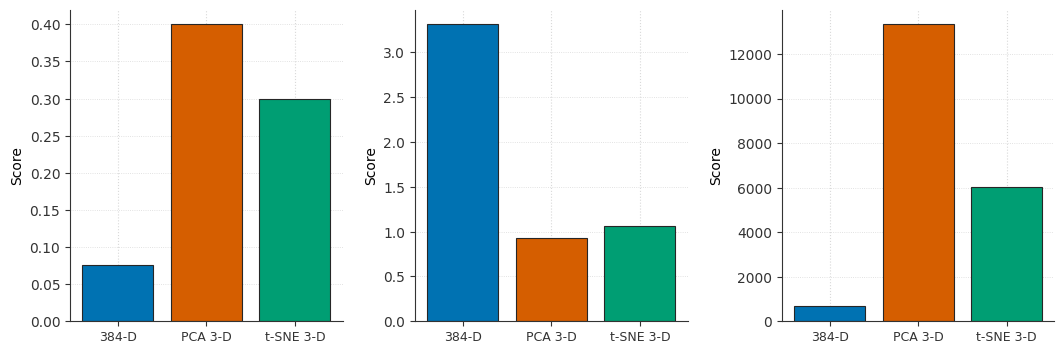

In [ ]:
# --- Recreate kmeans_metrics_k5_tripanel.png (COLOR, hi-DPI) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_df = None
for cand in ["kmeans_metrics_k5", "metrics_k5_df", "cluster_metrics_k5", "metrics_k5"]:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        _df = globals()[cand].copy()
        break

if _df is not None:
    cols = {c.lower(): c for c in _df.columns}
    space_col = cols.get("space") or cols.get("representation") or list(_df.columns)[0]
    sil_col   = cols.get("silhouette") or "silhouette"
    db_col    = cols.get("db") or cols.get("davies_bouldin") or "db"
    ch_col    = cols.get("ch") or cols.get("calinski_harabasz") or "ch"
    _df = _df[[space_col, sil_col, db_col, ch_col]].copy()
    _df.columns = ["space", "silhouette", "db", "ch"]
    _df["space"] = _df["space"].replace({
        "Original": "384-D", "384D": "384-D", "pca3": "PCA 3-D", "tsne3": "t-SNE 3-D"
    })
    _df = _df.set_index("space").reindex(["384-D", "PCA 3-D", "t-SNE 3-D"])
    sil_vals = _df["silhouette"].to_numpy()
    db_vals  = _df["db"].to_numpy()
    ch_vals  = _df["ch"].to_numpy()
else:
    sil_vals = np.array([sil_o,  sil_p,  sil_t], dtype=float)
    db_vals  = np.array([db_o,   db_p,   db_t], dtype=float)
    ch_vals  = np.array([ch_o,   ch_p,   ch_t], dtype=float)

spaces = ["384-D", "PCA 3-D", "t-SNE 3-D"]
metrics = {"Silhouette": sil_vals, "DB": db_vals, "CH": ch_vals}

plt.close("all")
fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.4), layout="constrained")
fig.set_constrained_layout_pads(w_pad=2/72, h_pad=2/72, wspace=0.06, hspace=0.06)

bars_colors = [C0, C1, C2]
for ax, (name, vals) in zip(axes, metrics.items()):
    for i, (v, col) in enumerate(zip(vals, bars_colors)):
        ax.bar(i, float(v), color=col, edgecolor="0.15", linewidth=0.8)
    ax.set_xticks(range(3))
    ax.set_xticklabels(spaces, fontsize=9)
    ax.set_ylabel("Score", fontsize=10)
    ax.yaxis.grid(True, linestyle=":", linewidth=0.6, color="0.85")
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

outpath = os.path.join(OUTDIR, "kmeans_metrics_k5_tripanel.png")
fig.savefig(outpath, dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.04)
print(f"Saved → {outpath}")